In [136]:
from CustomModel import CNN
from WavToTensor import AudioMnistDataset

import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from time import time

In [137]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('DEVUCE:',device)
print('USE CUDA:',torch.cuda.is_available())

DEVUCE: cpu
USE CUDA: False


In [138]:
learning_rate = 1e-3
num_epoch = 5
batch_size = 32

In [139]:
annotation_df = pd.read_csv('annotation.csv')
annotation_df = annotation_df.sample(frac=1)
annotation_df

,label,path
22209,4,C:\Users\Administrator\Desktop\Dataset\audio_m...
22321,6,C:\Users\Administrator\Desktop\Dataset\audio_m...
13345,6,C:\Users\Administrator\Desktop\Dataset\audio_m...
27938,8,C:\Users\Administrator\Desktop\Dataset\audio_m...
18115,2,C:\Users\Administrator\Desktop\Dataset\audio_m...
...,...,...
29184,3,C:\Users\Administrator\Desktop\Dataset\audio_m...
8007,0,C:\Users\Administrator\Desktop\Dataset\audio_m...
11778,5,C:\Users\Administrator\Desktop\Dataset\audio_m...
26648,2,C:\Users\Administrator\Desktop\Dataset\audio_m...


In [140]:
train_df = annotation_df.iloc[:int(len(annotation_df)*0.8),:]
val_df = annotation_df.iloc[int(len(annotation_df)*0.8):int(len(annotation_df)*0.9),:]
test_df = annotation_df.iloc[int(len(annotation_df)*0.9):,:]

In [141]:
train_df.to_csv('train_annotation.csv',index=False)
val_df.to_csv('val_annotation.csv',index=False)
test_df.to_csv('test_annotation.csv',index=False)

In [142]:
SAMPLE_RATE = 22050   
NUM_SAMPLES = 22050

transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(
        sample_rate = SAMPLE_RATE,
        n_fft= 512,
        win_length= 512,
        hop_length= 160,
        n_mels= 80),
    torchaudio.transforms.AmplitudeToDB()
    )

train_dataset = AudioMnistDataset(transformation=transforms,
                            target_sample_rate=22050,
                            num_samples=22050,
                            annotation_path=r'./train_annotation.csv',
                            device=device)

val_dataset = AudioMnistDataset(transformation=transforms,
                            target_sample_rate=22050,
                            num_samples=22050,
                            annotation_path=r'./val_annotation.csv',
                            device=device)

test_dataset = AudioMnistDataset(transformation=transforms,
                            target_sample_rate=22050,
                            num_samples=22050,
                            annotation_path=r'./test_annotation.csv',
                            device=device)
len(test_dataset)

3000

In [143]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(val_dataset,
                         batch_size=len(val_dataset),
                         drop_last=True)

test_loader = DataLoader(test_dataset,
                         batch_size=len(test_dataset),
                         drop_last=True)

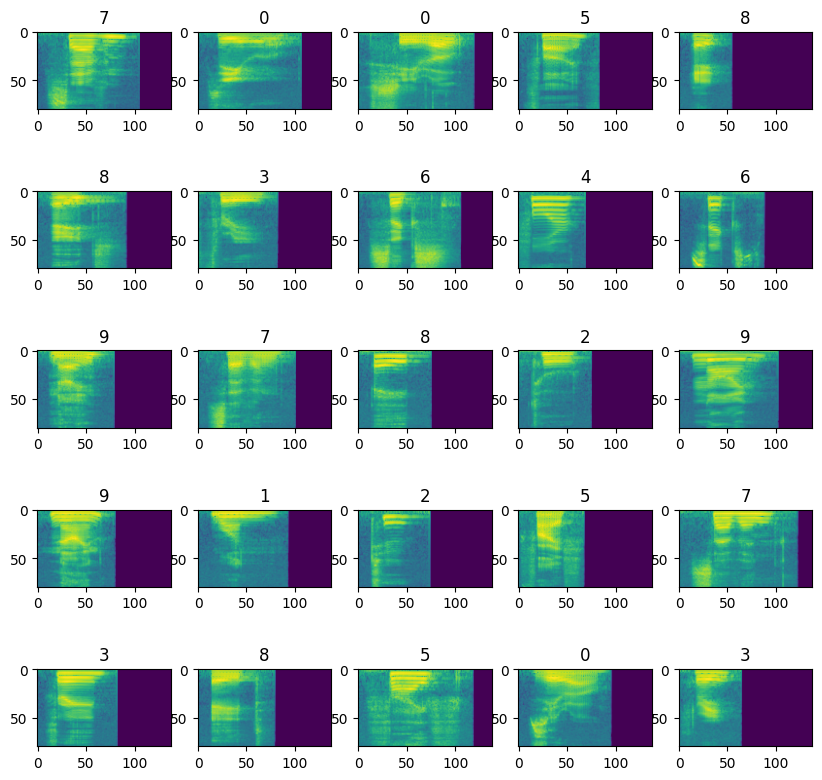

In [144]:
plt.figure(figsize=(10,10))

columns = 5
rows = 5

for i in range(1,rows*columns+1):
    randnum = np.random.randint(len(train_dataset))
    sample,label = train_dataset[randnum]
    plt.subplot(rows,columns,i)
    sample = sample.permute(1,2,0)
    plt.imshow(sample)
    plt.title(label)
plt.show()

In [145]:
model = CNN().to(device)

num_batch = len(train_loader)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [146]:
print('-'*25,'MODEL:',type(model).__name__,', learning start','-'*25)
for epoch in tqdm(range(num_epoch)):
    epoch_avg_loss = 0.0
    epoch_correct_count = 0

    for data in tqdm(train_loader):
        optimizer.zero_grad()

        audios, labels = data
        audios = audios.to(device)
        labels = labels.to(device)
        
        outputs = model(audios)
        loss = criterion(outputs,labels)
        
        batch_correct_count = sum(outputs.argmax(dim=-1)==labels).item()
        epoch_correct_count += batch_correct_count

        epoch_avg_loss += (loss/num_batch).item()

        loss.backward()
        optimizer.step()
    
    epoch_accuracy = epoch_correct_count/(batch_size*num_batch)*100
    
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            val_audios, val_labels = data
            val_audios, val_labels = val_audios.to(device), val_labels.to(device)
            val_outputs = model(val_audios)
            val_loss = criterion(val_outputs,val_labels)
            val_accuracy_count = (val_outputs.argmax(dim=-1) == val_labels).sum().item()
            val_accuracy_rate = val_accuracy_count/len(val_labels)*100
    model.train()
    print(f'[EPOCH: {epoch+1}/{num_epoch}] [LOSS: {loss:5f}] [ACCURACY: {epoch_accuracy:2f}%] [VAL_LOSS: {val_loss:5f}] [VAL_ACCURACY: {val_accuracy_rate:2f}%]')
print('-'*25,'MODEL:',type(model).__name__,', learning finished','-'*25)

------------------------- MODEL: CNN , learning start -------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

KeyboardInterrupt: 